In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams
import lmfit
import matplotlib.image as mpimg
from PIL import Image
from pathlib import Path
from collections import OrderedDict
import os
from lmfit.models import LorentzianModel
from scipy.optimize import curve_fit, OptimizeWarning
import json
from echodet_reader import read_wbfile, write_csv

In [4]:
# bokeh packages
from bokeh.io import output_file,show,output_notebook,push_notebook,curdoc
from bokeh.plotting import figure 
from bokeh.models import ColumnDataSource,HoverTool,CategoricalColorMapper, ColorBar, Select, Slider
from bokeh.palettes import Category10, Spectral6
from bokeh.layouts import row,column,gridplot,widgetbox
from bokeh.models.widgets import Tabs,Panel
from bokeh.transform import linear_cmap
output_notebook()
#curdoc().theme = 'dark_minimal'

Loading BokehJS ...

In [5]:
#Set Fonts/Plot Style
rcParams['figure.figsize'] = [12.0, 10.0]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 100
rcParams['font.size'] = 20
rcParams['legend.fontsize'] = 'small'
rcParams['figure.titlesize'] = 'medium'
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True
rcParams['xtick.major.size'] = 10
rcParams['ytick.major.size'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['ytick.minor.size'] = 5
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True

In [6]:
#all data
ves1  =      [ 'VES1', ("VES1_sqt.dat",""),]
ves2  =      [ 'VES2', ("VES2_sqt.dat",""),]

mic1  =      [ 'MCI1', ("MIC1_sqt.dat",""),]  
mic2  =      [ 'MCI2', ("MIC2_sqt.dat",""),]  

gel1  =      [ 'GEL1', ("GEL1_sqt.dat",""),]  
gel2  =      [ 'GEL2', ("GEL2_sqt.dat",""),] 

In [7]:
#reading the data file
def read_wbfile(filename):
    """
    Read b/w files produced by echodet
    
    Returns list of (metadata, data) pairs
    """
    result = []             # result
    data   = []             # data
    meta   = OrderedDict()  # meta data
    isdata = False
    iline  = 0
 
    with open(filename, 'rt') as fd:
        for line in fd.readlines():
            line = line.strip()
            if not line: continue
            iline += 1
            if iline <= 2:  # first two lines are info
                meta[f'info{iline}'] = line
                continue
            if line  == 'values':  # values indicate start of data block
                isdata = True
                continue
            if line == '#eod' or line == '#nxt':
                result.append((meta,np.asarray(data).T))
                data = []
                meta = OrderedDict()
                isdata = False
                iline  = 0
                if line == '#eod': break
                continue
      
            xl = line.split()
            if isdata:
                try:
                    data.append([float(x) for x in xl])
                except ValueError:
                    pass
            else:
                key   = xl[0]
                value = " ".join(xl[1:])
                try:
                    meta[key] = eval(value)
                except (ValueError, SyntaxError, NameError):
                    meta[key] = value
    return result

In [8]:
#checking the length of data
def prune_data(data, min_points=3, min_taus=3):
    """
    Prune/cleanup DrSPINE reduced data

    """
    if not len(data):
        return None
    data =  data.T
    data = data[data[:,5]>min_points] # at least min_points contributing points
    data = data[data[:,4]>0] # var(tau)
    data = data[data[:,3]>0] # var(sqt)
    data = data[data[:,2]>0] # err(sqt)
    data = data[data[:,1]>0] # require positive resultant sqt
    if len(data[:,4])<min_taus: # at least min_taus "good" taus
        return None
    return data.T

In [9]:
#plotting all data using tab plot
def tabs_plot(*args, **kwargs):
    data_dir= kwargs.pop('data_dir', 'Data')
    tabs=[]
    for sample in args:
        f=figure(x_axis_type="log", 
                    x_axis_label='tau(ns)', y_axis_label="s(q,t)/s(q,0)", 
                width=800, height=800)
        label  = sample[0]  # sample is defined like [ r'VES1', ("VES1_sqt1.dat",""),]

        for filename, slabel in sample[1:]:
            filename = os.path.join(data_dir, filename)
            if not os.path.exists(filename): continue
            dset = read_wbfile(filename)
            
            for (m, d), color  in zip((reversed(dset)),Category10[10]) :
                d     = prune_data(d, min_points=4)
                if d is None: continue
                q  = m['q']
                if q == 'NaN': continue

                dq   = m['q_var'] or 0.0
                tsam = m.get('temp_act') or m.get('temp')
                tau  = d[0]
                sqt  = d[1]
                dsqt = d[2]
                
                f.circle(tau, sqt, size=7, legend_label=f'Q={q}',color=color, alpha=1,
                         hover_color='purple', hover_alpha=0.6)
                f.legend.location="bottom"
                f.legend.label_text_font_size = '15pt'
            hover = HoverTool(tooltips=[ ('tau(ns)', '@x'), ("s(q,t)/s(q,0)", '@y')], mode='mouse')
            f.add_tools(hover)
            tab = Panel(child=f, title=label)
            tabs.append(tab)
    layout = Tabs(tabs=tabs)
    show(layout)

In [10]:
#defining fit function using lmfit
def fit_sqt(data, model='Zilman-Granek', **kwargs):

    A    = kwargs.pop('A',  1.0)
    A1   = kwargs.pop('A1',  1.0)
    G    = kwargs.pop('G',  1.0)
    t0   = kwargs.pop('t0', 1.0)
    t1   = kwargs.pop('t1', 1.0)
    B   = kwargs.pop('B', 1.0)
    beta = kwargs.pop('beta', 2.0/3.0)
    R    = kwargs.pop('R', 1.0)
    bounds  = kwargs.pop('bounds', (-np.inf, np.inf))
    init_par = kwargs.pop('init_par', None)
    max_tau = kwargs.pop('max_tau', np.inf)

    function_library = {
        'KWW'            : lambda t, t0, beta,B:         np.exp(-(t/t0)**beta)+B,   # simple KWW
        'KWW-Fix'        : lambda t, t0:               np.exp(-(t/t0)**beta),   # KWW with beta fixed
        'KWW-Norm'       : lambda t, t0, beta, A,B:    A*np.exp(-(t/t0)**beta)+B,   # KWW with prefactor
	    'KWW-Norm2'      : lambda t, t0, t1,beta, A, A1,B: A*np.exp(-(t/t0)**beta) + A1*np.exp(-(t/t1)**beta)+B,   # KWW with prefactor
        'KWW-Norm-Fix'   : lambda t, t0, A:          A*np.exp(-(t/t0)**beta),   # KWW with prefactor and beta fixed
        'Zilman-Granek'  : lambda t, G, B:                np.exp(-(G*t)**beta)+B,    # Zilman-Granek, KWW with b=2/3
        'Zilman-Granek-Norm'  : lambda t, G, A:      A*np.exp(-(G*t)**beta),    # Zilman-Granek, KWW with b=2/3
        'Exp'            : lambda t, t0, A:          A*np.exp(-(t/t0)),         # simple exponential function
        'Diffusion'      : lambda t, G:                np.exp(-G*q*q*t),        # simple diffusion
        'Diffusion-Norm' : lambda t, G,  A:          A*np.exp(-G*q*q*t),        # simple diffusion with prefactor
        'Diffusion+Const': lambda x, G,  A:      (1-A)*np.exp(-G*q*q*x)+A,      # simple diffusion with constant "background"
        'Power'          : lambda x, b,  A:      A*x**b,                        # power law
        'Linear'         : lambda x, x0, A:      A*(x-x0),                      # linear function
        'Constant'       : lambda x, A:          A*np.ones_like(x),             # constant
        'Cumulant'       : lambda x, c1, c2:     np.exp(-c1*x+c2*x**2/2.0),     # 2nd cumulant
        'Diffusion+2ND'  : lambda t, G,  c2:     np.exp(-G*q*q*t+c2*t*t) ,      # diffusion + 2nd cumuland
        'Richter-Rouse-Norm': lambda t, Ws, A: A*np.exp(-0.25*(q*R)**2) + A*(1-np.exp(-0.25*(q*R)**2))*np.exp(-q**2*np.sqrt(Ws*t/9/np.pi)), # RR
        'Richter-Rouse'  : lambda t, Ws, R:      np.exp(-0.25*(q*R)**2) +   (1-np.exp(-0.25*(q*R)**2))*np.exp(-q**2*np.sqrt(Ws*t/9/np.pi)), # RR
    }

    tau  = data[0]
    sqt  = data[1]
    serr = data[2]

    func = function_library.get(model, None)
    if func is None: raise RuntimeError(f"model {model} is invalid")
    fit_model = lmfit.Model(func,independent_vars='t',nan_policy='omit')
    
    if model.startswith('Zilman-Granek'):
        fit_pars = fit_model.make_params(G=1.909e-04,B=1)
        fit_pars['B'].set(min=0)  #only positive values
        fit_pars['G'].set(vary=True,min=0)

    elif model.startswith('KWW-Norm2'):
        fit_pars = fit_model.make_params(t0=0.01, beta=1, A=0.01, A1=0.1, t1=10,B=1)
        fit_pars['B'].set(min=0)  #only positive values
        fit_pars['t0'].set(vary=True,min=0)
        fit_pars['beta'].min=0
        fit_pars['A'].set(min=0)
        fit_pars['A1'].set(min=0)  #only positive values
        fit_pars['t1'].set(vary=True,min=0)
        
    else:
        fit_pars = fit_model.make_params(t0=1, beta=1, A=1, B=1)
        fit_pars['B'].set(min=0)  #only positive values
        fit_pars['t0'].set(vary=True,min=0)
        fit_pars['beta'].min=0
        fit_pars['A'].set(min=0)
        
    result = fit_model.fit(sqt,fit_pars,t=tau,method='least_squares')
    return result
    

In [14]:
#defining function for plotting and data
def main(*args, **kwargs):

    model = kwargs.pop('model', 'KWW-Norm') # fit model (see fit_sqt)
    mpars = kwargs.pop('model_pars', {} )   # model parameters
    rings = kwargs.pop('rings', (0,)   )    # which q-rings to use
    plot_summary = kwargs.pop('plot_summary', True)
    plot_fits    = kwargs.pop('plot_fits', True)
    data_dir     = kwargs.pop('data_dir', 'Data')


    results = []           # list of fit results
    print("# ", model)
    df=[]
    for sample in args:
        label  = sample[0]  # sample is defined like [ r'VES1', ("VES1_sqt1.dat",""),] 
        print()
        print("#"*30, label, "#"*30)
        print()
        if model.startswith('Diffusion'):
            print("# q     dq      D          B ")
        elif model.startswith('Zilman'):
            print("# q     dq      Gamma     B  ")
            print()
        elif model.startswith('KWW-Norm2'):
            print("# q     dq      tau0    tau1    beta     A     A1       B")
            print()
        else:
            print("# q     dq      tau0       beta      A     B")
            print()
        if plot_fits:
            plt.figure(figsize=(10,10))
            
        best_value = []
        outfile = label.replace('/','_').replace(' ','_').replace('=','').lower() # nice file name

        for filename, slabel in sample[1:]:
            filename = os.path.join(data_dir, filename)
            if not os.path.exists(filename): continue
            dset = read_wbfile(filename)
            
            for m, d in reversed(dset):
                d     = prune_data(d, min_points=4)
                if d is None: continue
                q  = m['q']
                if q == 'NaN': continue

                dq   = m['q_var'] or 0.0
                tsam = m.get('temp_act') or m.get('temp')
                tau  = d[0]
                sqt  = d[1]
                dsqt = d[2]
                
                alabel = r"Q=%.3f $\AA^{-1}$ %s" % (q, slabel)
                
                if plot_fits:
                    p = plt.errorbar(tau, sqt, yerr=dsqt,fmt='s', label=alabel)
                    acolor = p[0].get_color()
                    
                result=fit_sqt(d, model=model, **mpars)
                #report=result.fit_report()
                best_param=result.best_values
                values=[]
                for key, value in best_param.items():
                    values.append(value)
                values=[q, dq] + values
                print("\t".join([f'{x :.2g}' for x in values]), end=" ")
                print()
                if plot_fits:
                    fsqt = result.best_fit
                    plt.plot(tau, fsqt, '--', color=acolor) # fit
                best_value.append(values)

                #write_csv("%s-q-%.3f.csv" % (outfile,q), data, label=label, q=q, dq=dq)
        results.append((label, best_value))
        print()
        if plot_fits:
            plt.xscale('log')
            #plt.yscale('log')
            plt.xlim(left=0.05,right=150.0)
            plt.ylim(bottom=0.1, top=1.1)
            plt.xlabel(r'$\tau$ [ns]')
            plt.ylabel(r'$S(Q,\tau)/S(Q,0)$')
            plt.title("%s (%s)" % (label, model))
            plt.grid(which='both')
            plt.legend(loc=0)
            #figname=f"{str(outfile)}-sqt.pdf"
            #plt.savefig('Figures/'+figname)

    if plot_summary:
        plt.figure(figsize=(10,10))
        print("\n\n# SUMMARY")
        for label, fitres in results:
            fitres = np.asarray(fitres)
            fitres = fitres[fitres[:,0].argsort()].T
            #print(fitres)
            q     = fitres[0]
            dq    = fitres[1]
            par0  = fitres[2]
            
            p = plt.errorbar(q, par0, xerr=dq,
                fmt='o', label=label)
            acolor = p[0].get_color()

        plt.title("Model: %s" % model)
        plt.xlabel(r'$Q \; (\AA^{-1})$')

        if model.lower().startswith('diffusion'):
            plt.ylabel(r'D$\ \; (\AA^{2} ns^{-1}) $')
        elif model.lower().startswith('zilman'):
            plt.ylabel(r'$\Gamma \; (ns^{-1}) $')
        else:
            plt.ylabel(r'$\tau_0 \ \; (ns) $')


        plt.legend(loc='best')
        plt.grid(which='both')
        #plt.savefig(model.lower()+'-summary.pdf')
    plt.show()

                  

#  Diffusion-Norm

############################## VES1 ##############################

# q     dq      D          B 


KeyError: 'B'

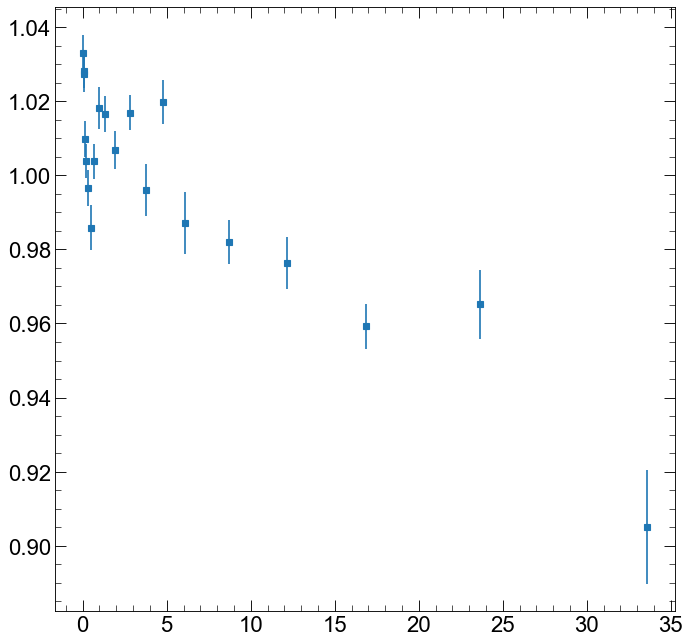

In [15]:
#model='KWW-Norm2',
main(ves1,ves2,
     mic1,mic2, 
     gel1,gel2,
     model='Diffusion-Norm',
     plot_summary=False, data_dir='Data',)

#  Zilman-Granek

############################## VES1 ##############################

# q     dq      Gamma     B  

0.13	0.00055	0.0009	0.02 
[1.01943027 1.01912553 1.01863365 1.01799163 1.01716093 1.01591852
 1.01484103 1.01322463 1.01156574 1.00934811 1.00623042 1.00203891
 0.9980841  0.9943742  0.98982234 0.9817729  0.97243455 0.96106337
 0.94653458 0.92803062]
[ 0.03881275  0.05657012  0.08958594  0.1397001   0.2147456   0.3455325
  0.4747704   0.6929972   0.9442971   1.319155    1.91398     2.825581
  3.792074    4.785059    6.109997    8.720422   12.1458     16.85157
 23.66563    33.57793   ]
0.12	0.00059	0.00091	0.029 
[1.02782423 1.02754615 1.02706793 1.02630494 1.02563687 1.02436798
 1.02327532 1.02167    1.0199094  1.01780584 1.01460869 1.01082233
 1.00583589 1.0030426  0.99825837 0.99047007 0.97989698 0.96942604
 0.95564499 0.93512849]
[ 0.04002305  0.05621691  0.08805244  0.1478571   0.2081277   0.3401591
  0.4701359   0.6852153   0.9507086   1.304485    1.91078     2.7251

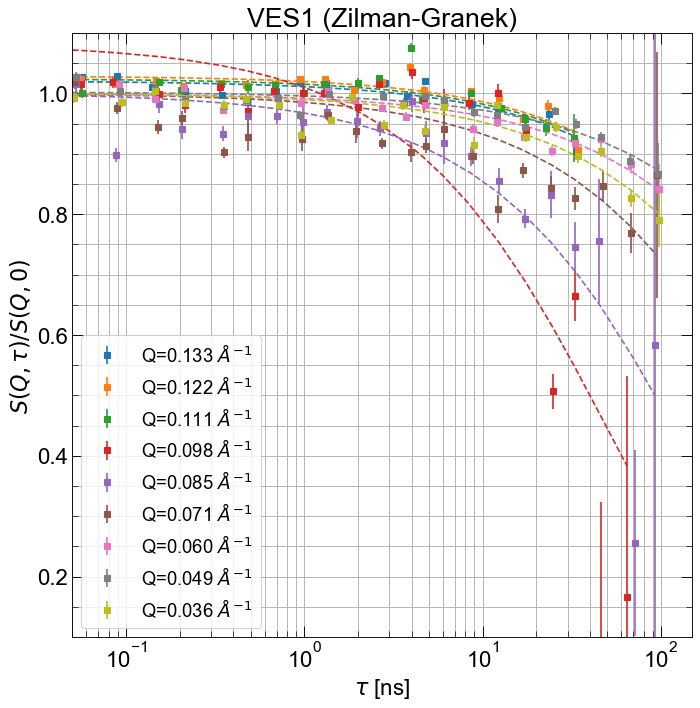

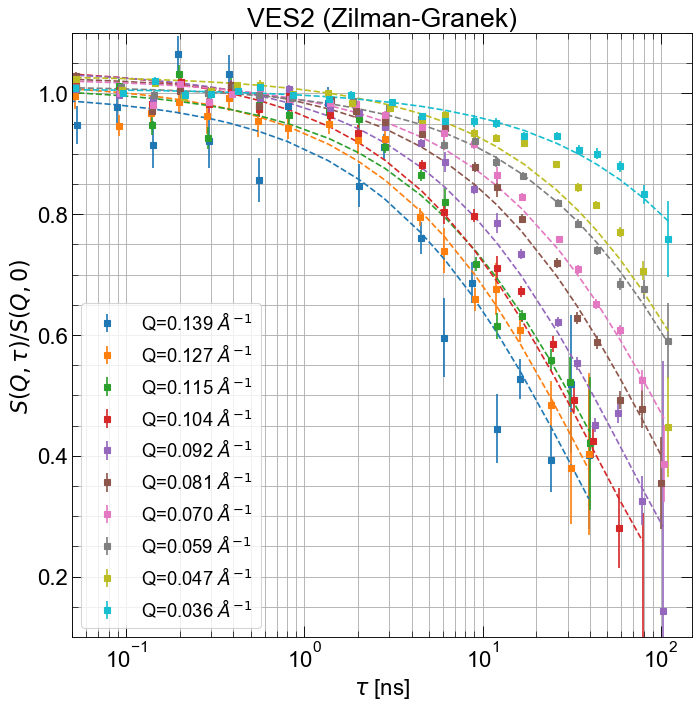

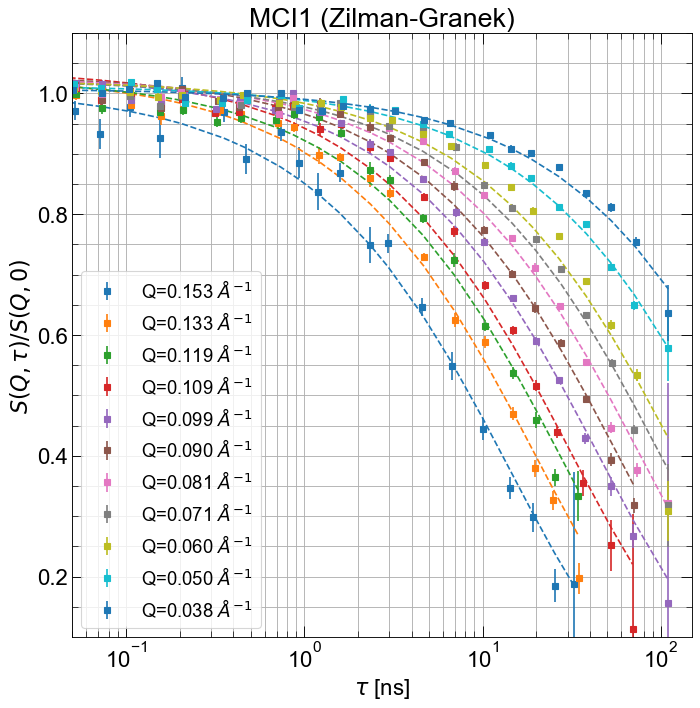

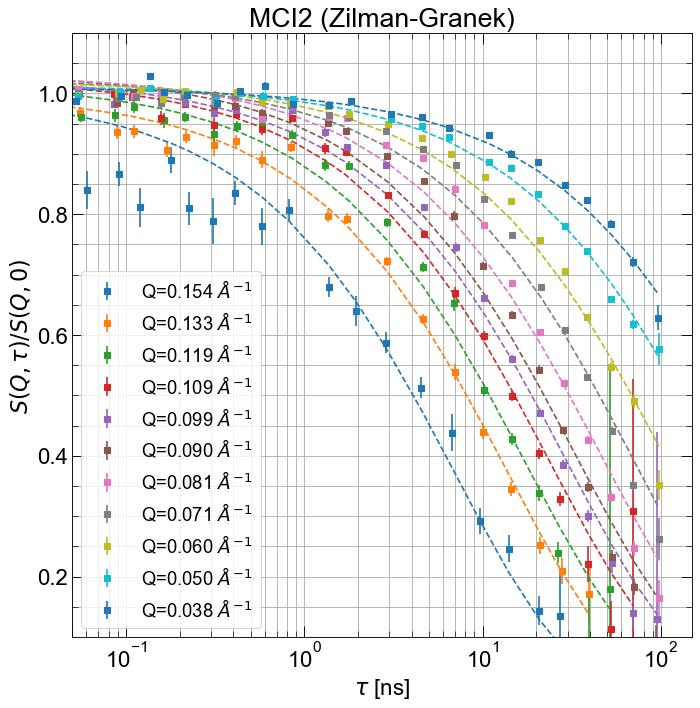

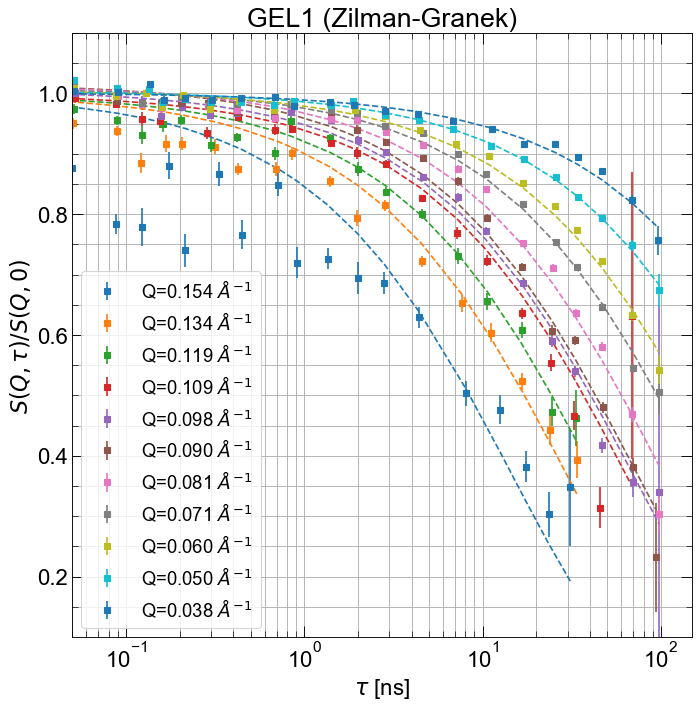

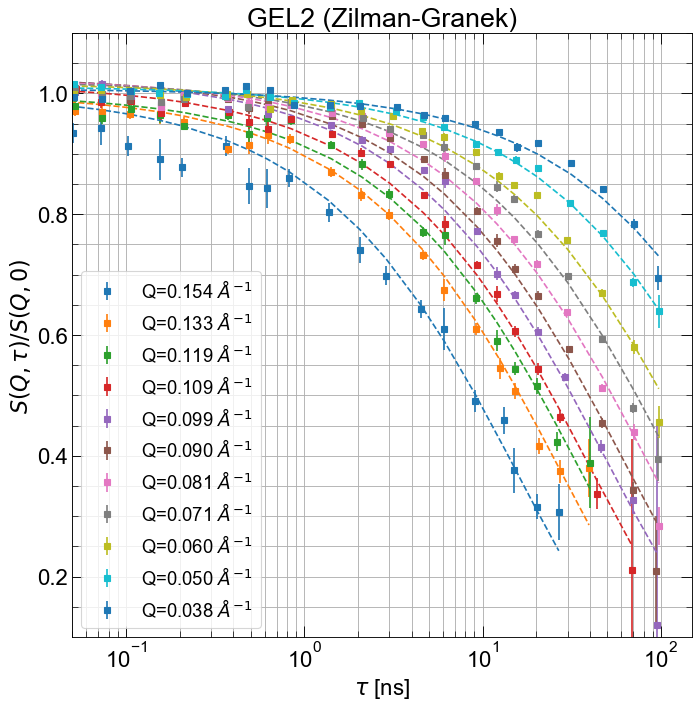

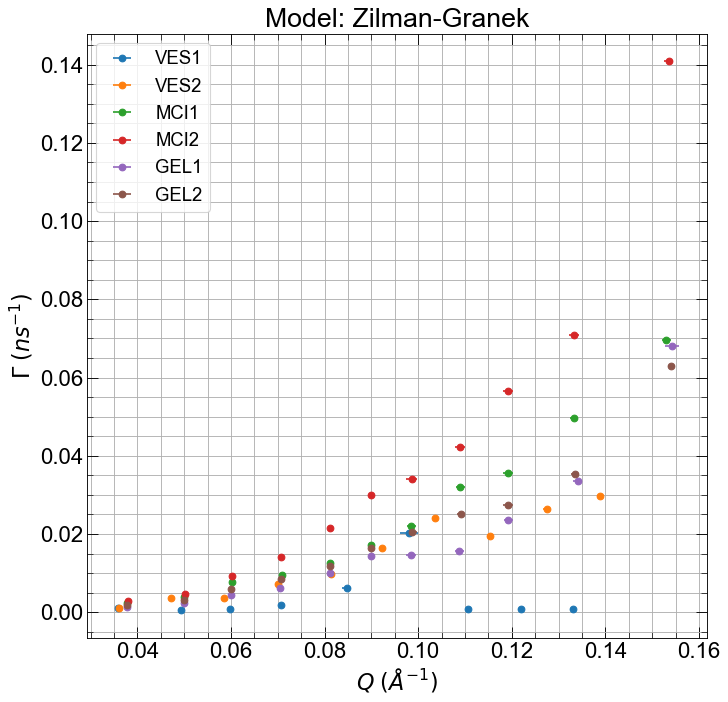

In [16]:
#model='KWW-Norm2',
main(ves1,ves2,
     mic1,mic2, 
     gel1,gel2,
     model='Zilman-Granek',
     plot_summary=True, data_dir='Data',)

In [69]:
#saving data in pandas dataframe
def main1(*args, **kwargs):

    model = kwargs.pop('model', 'KWW-Norm') # fit model (see fit_sqt)
    mpars = kwargs.pop('model_pars', {} )   # model parameters
    rings = kwargs.pop('rings', (0,)   )    # which q-rings to use
    plot_summary = kwargs.pop('plot_summary', True)
    plot_fits    = kwargs.pop('plot_fits', True)
    data_dir     = kwargs.pop('data_dir', 'Data')


    results = []           # list of fit results
    print("# ", model)
    df=[]
    for sample in args:
        label  = sample[0]  # sample is defined like [ r'VES1', ("VES1_sqt1.dat",""),] 
        
        if plot_fits:
            plt.figure(figsize=(8,8))
        fit_res=[]
        outfile = label.replace('/','_').replace(' ','_').replace('=','').lower() # nice file name

        for filename, slabel in sample[1:]:
            filename = os.path.join(data_dir, filename)
            if not os.path.exists(filename): continue
            dset = read_wbfile(filename)
            r = []; ks = [];
            for m, d in reversed(dset):
                d     = prune_data(d, min_points=4)
                if d is None: continue
                q  = m['q']
                if q == 'NaN': continue

                dq   = m['q_var'] or 0.0
                tsam = m.get('temp_act') or m.get('temp')
                tau  = d[0]
                sqt  = d[1]
                dsqt = d[2]
                
                alabel = r"Q=%.3f $\AA^{-1}$ %s" % (q, slabel)
                
                if plot_fits:
                    p = plt.errorbar(tau, sqt, yerr=dsqt,fmt='s', label=alabel)
                    acolor = p[0].get_color()
                    
                result=fit_sqt(d, model=model, **mpars)
                #report=result.fit_report()
                if plot_fits:
                    fsqt = result.best_fit
                    plt.plot(tau, fsqt, '--', color=acolor) # fit
                ks.append(q)
                r.append(result.best_values)
        
                df=pd.DataFrame(r,index=ks)
                #write_csv("%s-q-%.3f.csv" % (outfile,q), data, label=label, q=q, dq=dq)
        results.append(df)
        print(label)
        if plot_fits:
            plt.xscale('log')
            #plt.yscale('log')
            plt.xlim(left=0.05,right=150.0)
            plt.ylim(bottom=0.1, top=1.1)
            plt.xlabel(r'$\tau$ [ns]')
            plt.ylabel(r'$S(Q,\tau)/S(Q,0)$')
            plt.title("%s (%s)" % (label, model))
            plt.grid(which='both')
            plt.legend(loc=0)
            #figname=f"{str(outfile)}-sqt.pdf"
            #plt.savefig('Figures/'+figname)
    print(results)
    plt.show()
                    
                

#  KWW-Norm2
VES1
VES2
MCI1
MCI2
GEL1
GEL2
[                t0           t1       beta           A        A1             B
0.132985  0.100265   166.406955   1.440441    0.036594  1.005725  1.458888e-08
0.121940  0.022555   167.929593   1.394799    0.216883  1.017733  5.888060e-10
0.110724  0.003590    16.884947   2.180236    9.217752  0.089335  9.267244e-01
0.098051  0.000115    33.937651   3.001318   49.872523  0.908843  9.394171e-02
0.084701  0.047682    45.559735   2.344595    0.216650  0.498600  4.401559e-01
0.070766  0.090911     9.015954  43.448190    0.070086  0.102578  8.330175e-01
0.059803  0.087289   114.356094   0.679462    0.021936  0.240790  7.563995e-01
0.049209  0.000061  1215.646065   0.772061  219.588813  0.999417  1.947127e-09
0.035818  0.611018    64.877297   2.041681    0.036493  0.189298  7.701402e-01,                     t0          t1      beta             A        A1  \
0.138881  2.429768e-03    7.445537  1.706826  1.810247e+01  0.487986   
0.127452  1.172235e-0

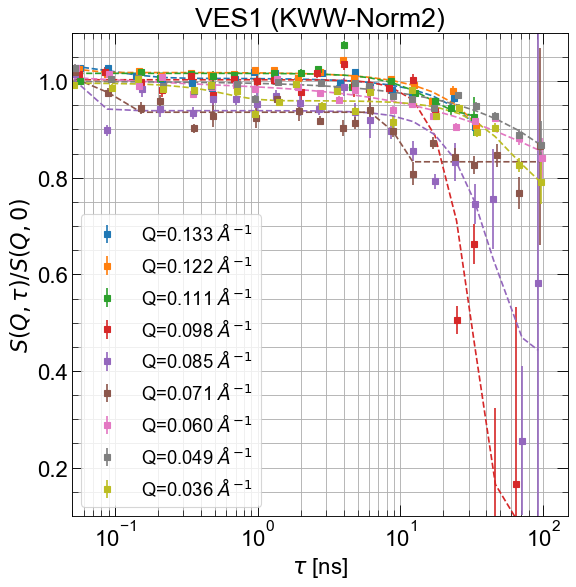

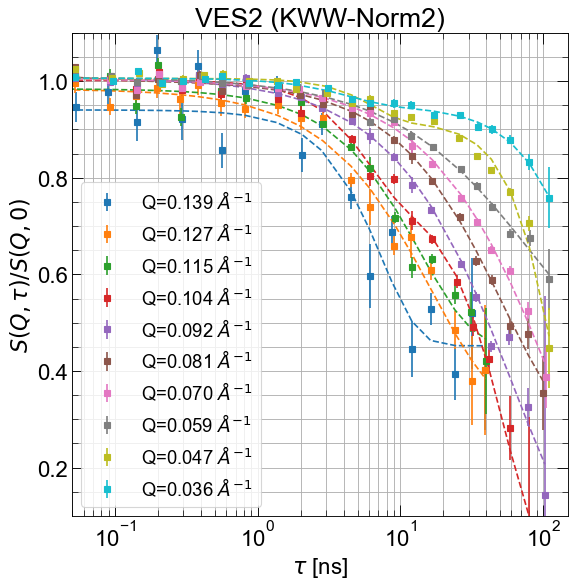

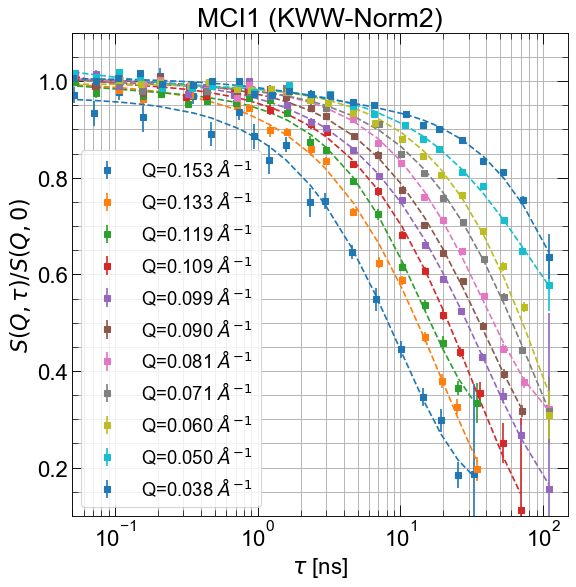

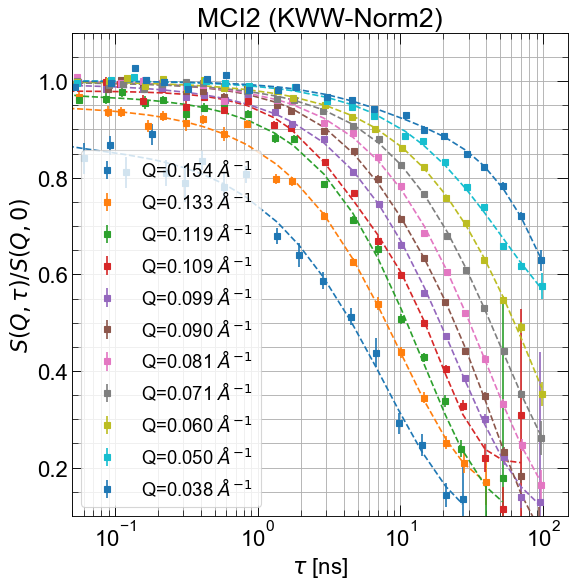

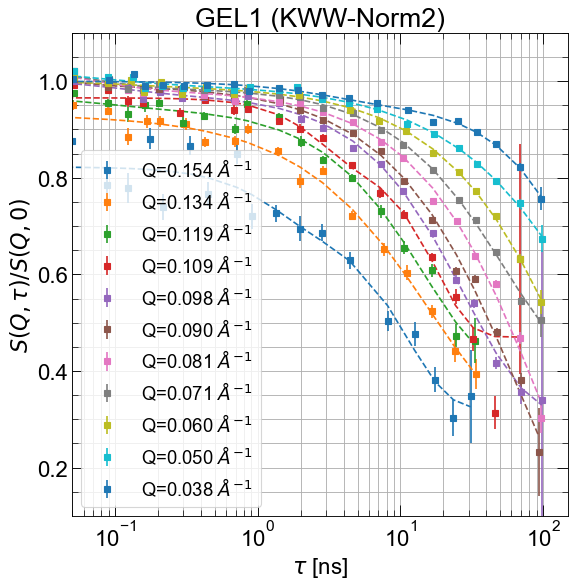

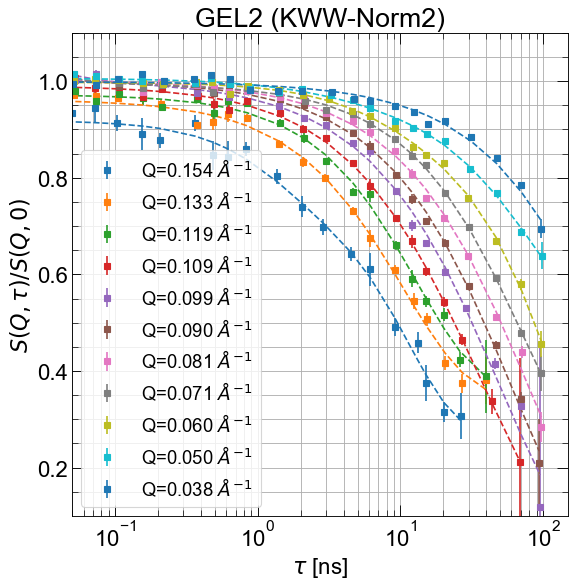

In [70]:
main1(ves1,ves2,
     mic1,mic2, 
     gel1,gel2,
     model='KWW-Norm2',
     plot_summary=False, data_dir='Data',)

In [67]:
#some functions
def KWW( t, t0, beta,B):         
    return np.exp(-(t/t0)**beta),   # simple KWW
        
def KWW_Fix(t, t0, B):               
    return np.exp(-(t/t0)**beta),   # KWW with beta fixed
        
    
def KWW_Norm(t, t0, beta, A, B):    
    return A*np.exp(-(t/t0)**beta),   # KWW with prefactor
def KWW_Norm2(t, t0, t1,beta, A, A1, B): 
    return A*np.exp(-(t/t0)**beta) + A1*np.exp(-(t/t1)**beta)+B,   # KWW with prefactor

def Zilman_Granek(t, G):                
    return np.exp(-(G*t)**beta)+B,    # Zilman-Granek, KWW with b=2/3